# Performance Analysis of FC Barcelona (2014–2025) - A Data-Driven Investigation of Performance, Efficiency, and Financial Constraints

## Libraries & Setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

### Load Data


In [3]:
# scrape and load needed dataset for analysis
# df1 = pd.read_html('https://fbref.com/en/squads/206d90db/history/Barcelona-Stats-and-History#all_comps_fa_club_league', attrs={"id" : "comps_fa_club_league"})[0]
# df1.to_csv('./data/raw/la_liga_stats.csv')

# df2 = pd.read_html('https://fbref.com/en/squads/206d90db/history/Barcelona-Stats-and-History#all_comps_fa_club_league', attrs={"id" : "comps_intl_club_cup"})[0]
# df2.to_csv('./data/raw/champions_league_stats.csv')

df1 = pd.read_csv("./data/raw/la_liga_stats.csv")
df2 = pd.read_csv("./data/raw/champions_league_stats.csv")

# datasets 3-4-5 are manually collected and cleaned in Excel
df3 = pd.read_csv('./data/processed/fcb_deeper_stats.csv')
df4 = pd.read_csv('./data/processed/squad_cost_limit.csv')
df5 = pd.read_csv('./data/processed/transfer_spending.csv')

### Data Exploration

In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       38 non-null     int64  
 1   Season           37 non-null     object 
 2   Squad            37 non-null     object 
 3   Comp             37 non-null     object 
 4   LgRank           37 non-null     object 
 5   MP               37 non-null     float64
 6   W                37 non-null     float64
 7   D                37 non-null     float64
 8   L                37 non-null     float64
 9   GF               37 non-null     float64
 10  GA               37 non-null     float64
 11  GD               37 non-null     float64
 12  Pts              37 non-null     float64
 13  Attendance       13 non-null     float64
 14  Top Team Scorer  37 non-null     object 
 15  Goalkeeper       31 non-null     object 
 16  Notes            2 non-null      object 
dtypes: float64(9), int

### Data Cleaning & Transformation

#### Drop irrelevant rows and columns

In [5]:
# drop irrelevant columns and rows
df1 = df1.drop([0] + list(range(12, 38))).reset_index(drop=True)
df1 = df1.drop(['Unnamed: 0', 'Squad', 'Country', 'Attendance', 'Top Team Scorer', 'Goalkeeper' , 'Notes'], axis=1)
df2 = df2.drop([0] + list(range(14, 38))).reset_index(drop=True)
df2 = df2.drop(['Unnamed: 0', 'Attendance', 'Top Team Scorer', 'Goalkeeper', 'Notes', 'Squad'], axis=1)
indices_to_drop = df3[df3['Ball Situation'] == 'Set piece'].index
df3 = df3.drop(indices_to_drop).reset_index(drop=True)
df4 = df4.drop(list(range(0, 5))).reset_index(drop=True)

#### Rename column names to avoid ambiguity between La Liga and UEFA Champions League datasets

In [6]:
# rename columns to avoid ambiguity
df1.rename(columns={"Comp" : "Domestic Comp", "LgRank" : "Domestic Rank", "MP" : "Domestic Match Played", 
                    "W" : "Domestic W", "D" : "Domestic D", "L" : "Domestic L", "GF" : "Total GF", 
                    "GA" : "Total GA", "GD" :"Domestic GD", "Pts" : "Domestic Pts"}, inplace=True)

df2.rename(columns={"Comp" : "Intl Comp", "LgRank" : "Stage Reached", "MP" : "UCL Match Played", 
                    "W" : "UCL W", "D" : "UCL D", "L" : "UCL L", "GF" : "UCL GF", 
                    "GA" : "UCL GA", "GD" :"UCL GD", "Pts" : "UCL Pts"}, inplace=True)

#### Standardize season format using lambda function
> `2014/15 → 14/15`

In [7]:
# standardize season format for later visualizing
df1["Season"] = df1["Season"].str.split("-").apply(lambda x: x[0][2:] + "/" + x[1][2:])
df2['Season'] = df2['Season'].str.split("-").apply(lambda x: x[0][2:] + "/" + x[1][2:])

#### Order the season from furthest season & Convert rank to numeric & Convert data type
> `14/15 - 15/16 - ...`

> `1st → 1`

In [8]:
# resort season values from oldest season
df1 = df1.sort_values("Season").reset_index(drop=True)
df2 = df2.sort_values("Season").reset_index(drop=True)

# merge table for overall information in domestic competition
merged_df = pd.merge(df1, df3, on=['Season'], how='right')

# convert rank into numeric
merged_df['Domestic Rank'] = merged_df['Domestic Rank'].str[:-2].astype('int')

# strip any space if any
merged_df.columns = merged_df.columns.str.strip()
merged_df.to_csv('./data/processed/laliga_season_level_stats.csv')

# converting data type 
df2 = df2.astype({'UCL Match Played' : 'int', 'UCL W' : 'int', 'UCL D' : 'int', 'UCL L' : 'int', 'UCL GF' : 'int', 
                  'UCL GA' : 'int', 'UCL GD' : 'int', 'UCL Pts' : 'int'})

## Exploratory Data Analysis (EDA)

### La Liga Performance Trends (2014/2015 - 2024/2025)
- Use line plots to visualize:
  - **Total Goals vs Final Rank**: Identify peak attacking periods and recovery

In [9]:
# move ball situation column to the front
merged_df = merged_df[ ["Ball Situation"] + [col for col in merged_df.columns if col != "Ball Situation"] ]
merged_df.head()

,Ball Situation,Season,Domestic Comp,Domestic Rank,Domestic Match Played,Domestic W,Domestic D,Domestic L,Total GF,Total GA,Domestic GD,Domestic Pts,Total Shots,GF,GA,xG,xGA
0,Open play,14/15,1. La Liga,1,38,30,4,4,110,21,89,94,487,88,14,89.02,20.45
1,Corner kick,14/15,1. La Liga,1,38,30,4,4,110,21,89,94,71,8,2,6.69,3.61
2,Free kick,14/15,1. La Liga,1,38,30,4,4,110,21,89,94,43,3,0,3.07,1.22
3,Open play,15/16,1. La Liga,1,38,29,4,5,112,29,83,91,454,84,25,88.79,29.41
4,Corner kick,15/16,1. La Liga,1,38,29,4,5,112,29,83,91,56,9,3,8.75,3.98


- Allowing residual axis by defining:

    ```
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ```
    - Where ax1 indicates `Total GF`

- Then use `twinx()` to create secondary y-axis


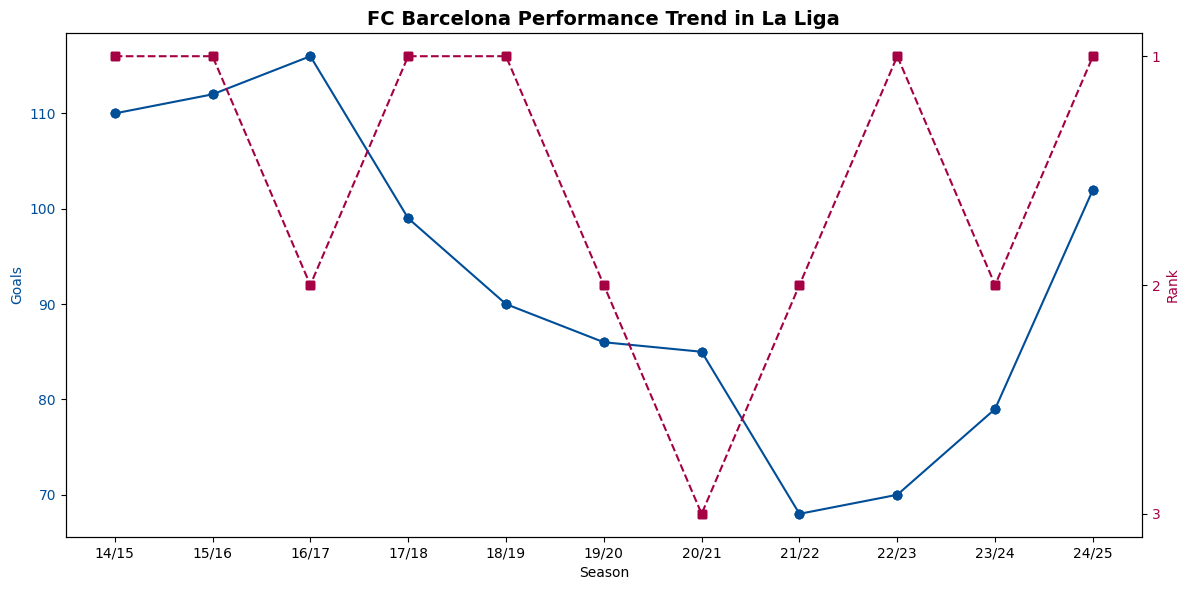

In [10]:
# Domestic stats visualize
## ========== PLOT 1: Goals & League Rank ==========
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_df["Season"], merged_df["Total GF"], marker='o', color='#004D98', label="Total Goals")
ax1.set_xlabel("Season")
ax1.set_ylabel("Goals", color='#004D98')
ax1.tick_params(axis='y', labelcolor='#004D98')

## find max & min rank available
max_rank = int(merged_df["Domestic Rank"].max())
min_rank = int(merged_df["Domestic Rank"].min())

## create 2nd y-axis
ax2 = ax1.twinx()

## set values for the 2nd y-axis
ax2.set_yticks(np.arange(min_rank, max_rank + 1, 1))

ax2.plot(merged_df["Season"], merged_df["Domestic Rank"], marker='s', color='#A50044', linestyle="--", label="Rank")
ax2.set_xlabel("Season")
ax2.set_ylabel("Rank", color='#A50044')
ax2.tick_params(axis='y', labelcolor='#A50044')

## 1st rank on top
ax2.invert_yaxis()

plt.title("FC Barcelona Performance Trend in La Liga", fontsize="14", fontweight="bold")
plt.tight_layout()
plt.savefig("./outputs/figures/goals_vs_rank.png")
plt.show()


### Insights About FC Barcelona's Performance in Domestic Competition over The Past Decade
- Goals scored peak between 14/15 and 16/17, and then declined gradually, reaching the lowest in 2022.

### Defensive Weakness Analysis
- Use line plots to visualize:
  - **Goals For & Against & Goal Difference**: Examine defensive weaknesses
  - Showing 2 line charts in the same figure better visualization by defining:

    ```
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False)
    ```
  
- Interpretation of weaknesses in defense based on the decline in goals score and goals difference, and high goals against

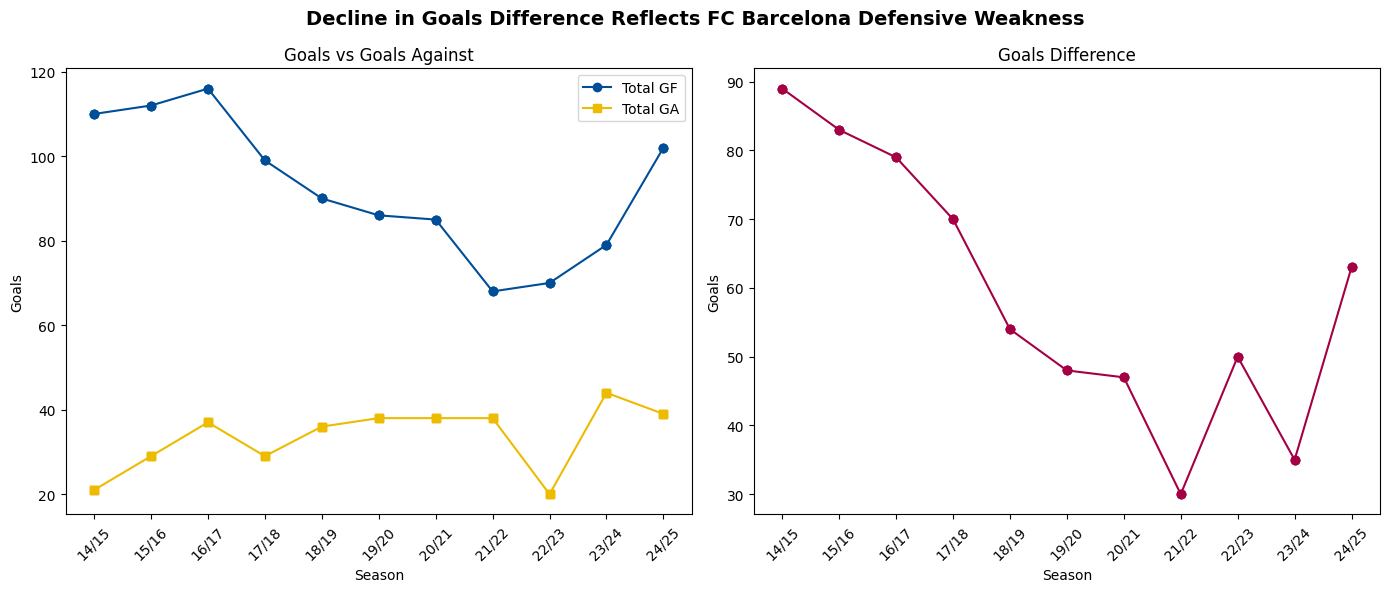

In [11]:
## ========== PLOT 2: Goals For, Goals Against, and Goals Difference ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False)

axes[0].plot(merged_df['Season'], merged_df['Total GF'], marker='o', color='#004D98', label='Total GF')
axes[0].plot(merged_df['Season'], merged_df['Total GA'], marker='s', color='#EDBB00', label='Total GA')
axes[0].set_title("Goals vs Goals Against")
axes[0].set_xlabel("Season")
axes[0].set_ylabel("Goals")
axes[0].legend()
axes[0].tick_params(axis='x', rotation= 45)

axes[1].plot(merged_df['Season'], merged_df['Domestic GD'], marker='o', color='#A50044')
axes[1].set_title("Goals Difference")
axes[1].set_xlabel("Season")
axes[1].set_ylabel("Goals")
axes[1].tick_params(axis='x', rotation= 45)

plt.suptitle("Decline in Goals Difference Reflects FC Barcelona Defensive Weakness", fontsize="14", fontweight="bold")
plt.savefig("./outputs/figures/goals_vs_goals-against.png")
plt.tight_layout()
plt.show()

### Insights About Their Weakenesses in Defense Based on Scoring Trends
- Goal difference decreased steadily after the 14/15 season.
- 21/22 marked the lowest level in FC Barcelona's performance, with lowest goals scored but high goals conceded.
- Improvement under Xavi (22/23) but inconsistency remains

### Finishing Efficiency (GF / xG) by Ball Situation
- Use bar charts to visualize:
  - **Finishing Efficiency by Ball Situation**: Computing `GF/xG` for open play, free kicks, corners
- Interpretation of over/underperformance

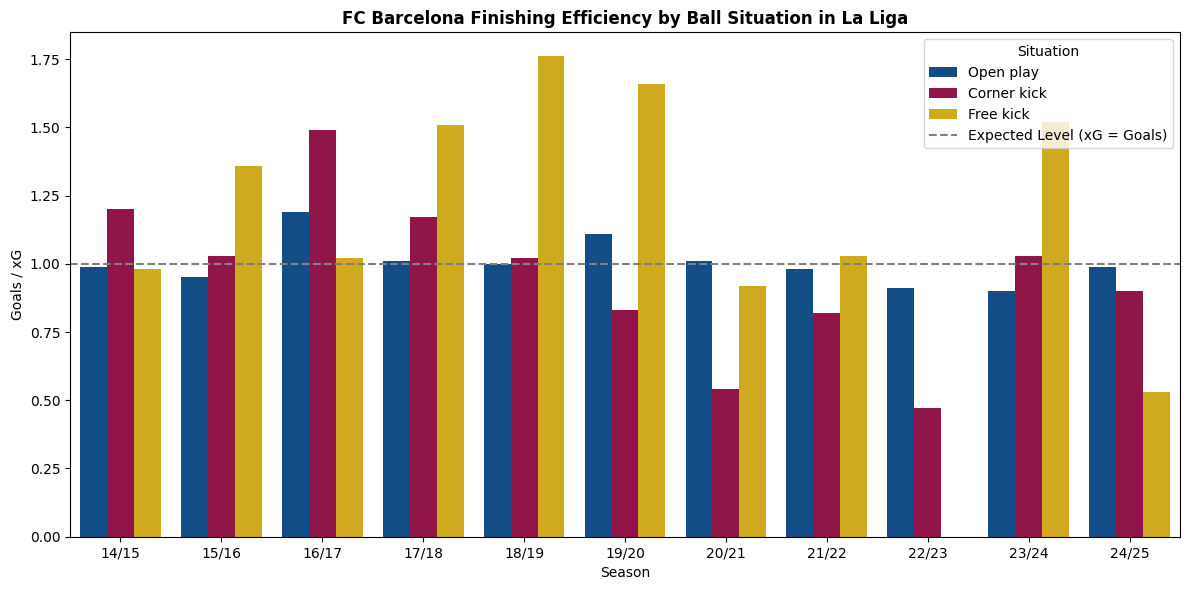

In [12]:
## ========== PLOT 3: Goals and Expected Goals ==========
plt.figure(figsize=(12, 6))

merged_df['Finishing_eff'] = (merged_df['GF'] / merged_df['xG']).round(2)

# plot based on ball situation
sns.barplot(x='Season', y='Finishing_eff', hue='Ball Situation', data=merged_df, palette=['#004D98','#A50044', '#EDBB00'])
plt.axhline(1, color='gray', linestyle='--', label='Expected Level (xG = Goals)')
plt.title('FC Barcelona Finishing Efficiency by Ball Situation in La Liga', fontweight="bold")
plt.ylabel('Goals / xG')
plt.legend(title='Situation')

plt.tight_layout()


### Insights About Their Finishing Efficiency Based on Goals-For (GF) and Expected-goals (xG)
- Open-play efficiency dropped below 1.0 after 19/20
- Set-piece efficiency weakened dramatically after 2021, coincided with Messi departure, showing reliance on key players

### International Performance - UEFA Champions League (UCL)
- Use line plots to visualize:
  - **Stage Progression**: Win, Quarter-Finals, Semi-Finals, Round of 16, Group stage
  - **Special cases**: Demotion to UEFA Europa League - UEL (Knockout stages)
- Use bar charts to show UCL scoring trend:
  - Goals For & Goals Against (UCL only)

In [13]:
# converting stage reached to numeric for visualizing
stage_map = {
    "KO": 1, "GR": 2, "R16": 3, "QF": 4, "SF": 5, "W": 6,
}
df2["Stage Progression"] = df2["Stage Reached"].map(stage_map)
df2.head()

,Season,Intl Comp,Stage Reached,UCL Match Played,UCL W,UCL D,UCL L,UCL GF,UCL GA,UCL GD,UCL Pts,Stage Progression
0,14/15,1. Champions Lg,W,13,11,0,2,31,11,20,33,6
1,15/16,1. Champions Lg,QF,10,7,2,1,22,8,14,23,4
2,16/17,1. Champions Lg,QF,10,6,1,3,26,12,14,19,4
3,17/18,1. Champions Lg,QF,10,6,3,1,17,6,11,21,4
4,18/19,1. Champions Lg,SF,12,8,3,1,26,10,16,27,5


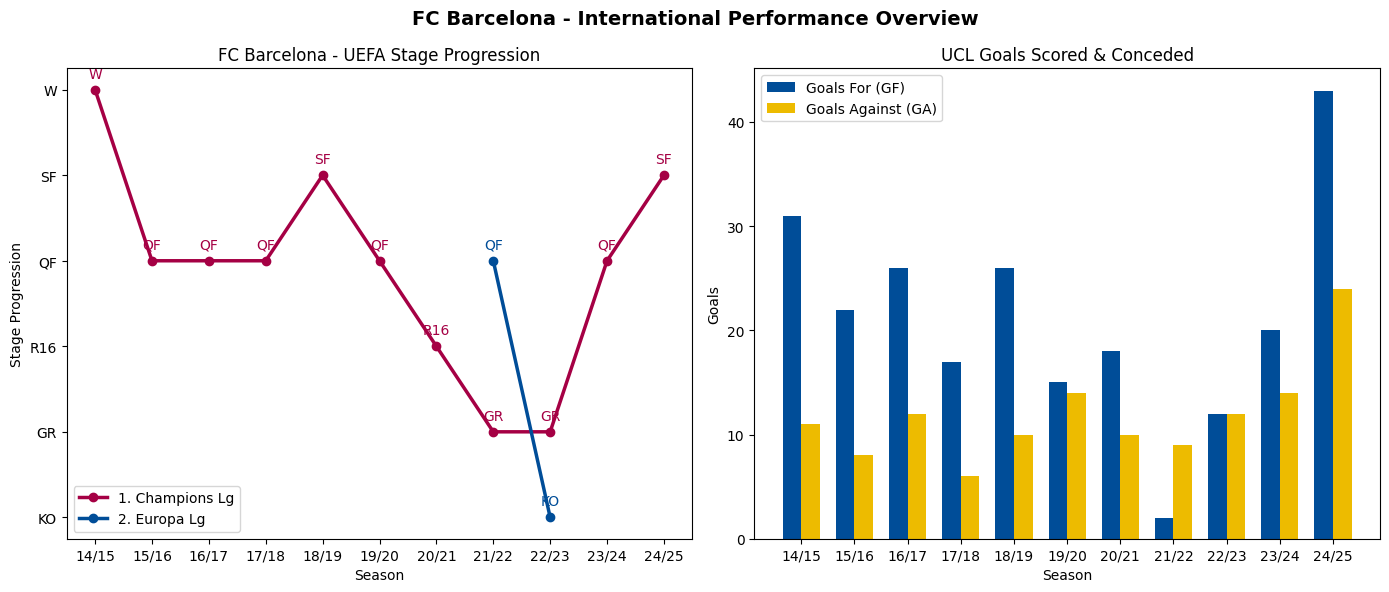

In [21]:
# ## stats visualize
# #========== PLOT: Goals and Rank ==========
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=False)

# color palette
colors = {"1. Champions Lg": "#A50044", "2. Europa Lg": "#004D98"}

# stage progression
for comp in df2["Intl Comp"].unique():
    comp_df = df2[df2["Intl Comp"] == comp].sort_values("Season")

    ax1.plot(
        comp_df["Season"],
        comp_df["Stage Progression"],
        marker="o",
        linestyle="-",
        linewidth=2.5,
        color=colors[comp],
        label=comp
    )

    # annotation for each stage
    for x, y, txt in zip(comp_df["Season"], comp_df["Stage Progression"], comp_df["Stage Reached"]):
        ax1.text(x, y + 0.14, txt, ha="center", color=colors[comp])

ax1.set_title("FC Barcelona - UEFA Stage Progression")
ax1.set_xlabel("Season")
ax1.set_ylabel("Stage Progression")

ax1.set_yticks(list(stage_map.values()))
ax1.set_yticklabels(list(stage_map.keys()))

ax1.legend(loc="lower left")

# goals for & goals against of Champions League only
ucl = df2[df2["Intl Comp"] == "1. Champions Lg"]
x = np.arange(len(ucl))  
width = 0.35
ax2.bar(x - width/2, ucl["UCL GF"], width, color="#004D98", label="Goals For (GF)")
ax2.bar(x + width/2, ucl["UCL GA"], width, color="#EDBB00", label="Goals Against (GA)")

ax2.set_title("UCL Goals Scored & Conceded")
ax2.set_xlabel("Season")
ax2.set_ylabel("Goals")
ax2.set_xticks(x)
ax2.set_xticklabels(ucl["Season"])
ax2.legend()

plt.suptitle("FC Barcelona - International Performance Overview", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("./outputs/figures/goals_vs_goals-against.png")
plt.show()

### Insights About Their International Performance
- 8 eliminations in Quarter/Semi finals since 2015
- Demoted to Europa League in 21/22 and 22/23, Round of 16 failure in 21/22 and Round of 32 failure in 22/23
- Goals scored improved recently, but knockout failures persist

### Financial Analysis
Financial Data includes data of the current season (2025/26) for better understanding of the club's financial situation throughout the years

#### Transfer Sum (€M):
- Line plot with total amount spent (in €B)
- Highlight years with high amount of spending
- Discuss poor financial management

In [15]:
df5.head()

,Season,Transfer sum
0,14/15,166.72
1,15/16,51.00
2,16/17,124.75
3,17/18,413.10
4,18/19,141.10


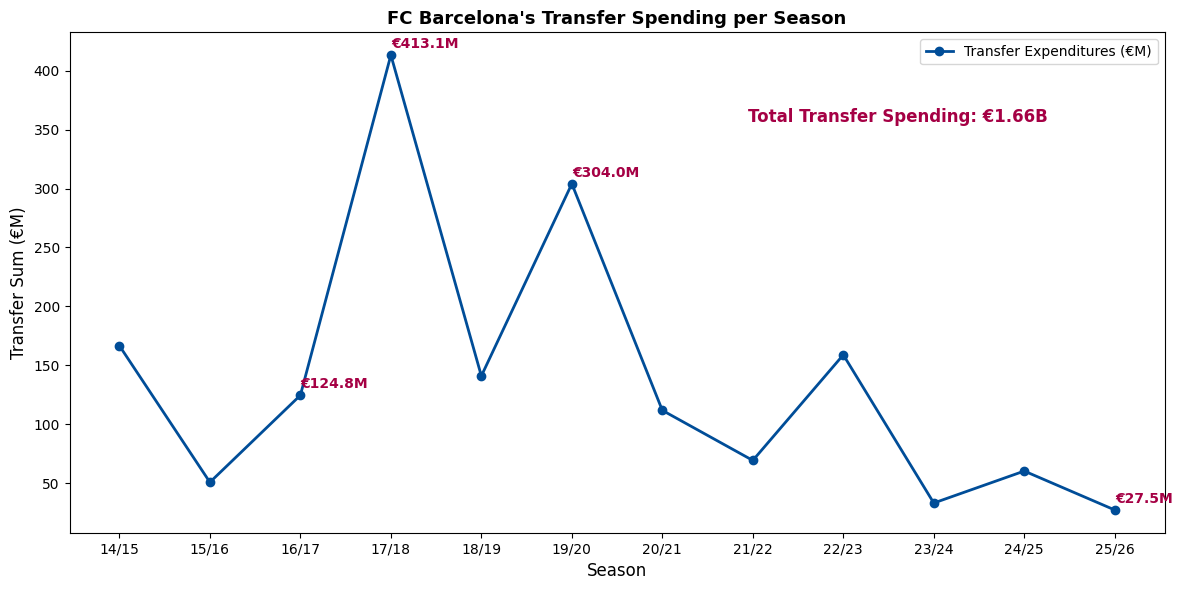

In [16]:
# Financial Analysis
## ========== PLOT 1: Transfer Spending ==========
plt.figure(figsize=(12, 6))
plt.plot(
    df5["Season"],
    df5["Transfer sum"],
    marker="o",
    color="#004D98",
    linewidth=2,
    label="Transfer Expenditures (€M)"
)

plt.title("FC Barcelona's Transfer Spending per Season", fontsize=13, weight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Transfer Sum (€M)", fontsize=12)
total_spending = df5["Transfer sum"].sum()/1000

# add annotation
plt.text(
    0.62, 0.82, f"Total Transfer Spending: €{total_spending:.2f}B", transform=plt.gca().transAxes,
    fontsize=12, color="#A50044", weight='bold'
)

highlight_seasons = ["16/17", "17/18", "19/20", "25/26"]

for season in highlight_seasons:
    value = df5.loc[df5["Season"] == season, "Transfer sum"].values[0]
    plt.annotate(
        f"€{value:.1f}M",                   
        xy=(season, value),                
        xytext=(0, 5),                      
        textcoords='offset points',
        ha='left',                        
        fontsize=10,
        color="#A50044",
        weight='bold'
    )
plt.legend()
plt.tight_layout()
plt.savefig("./outputs/figures/transfer_expenditures.png")

### Insights About Amount Spending on Transfer Market 
- €1.1B+ spent between 2016–2020 with minimal impacts and poor returns on investments

#### Squad Cost Limit
- Compare between FC Barcelona vs Real Madrid
- Year with negative limit
- Impact on transfer and performance

In [17]:
df4

,Season,Team,Squad Cost Limit
0,19/20,FC Barcelona,671.40
1,20/21 (Sep),FC Barcelona,382.71
2,20/21 (Feb),FC Barcelona,347.07
3,21/22 (Sep),FC Barcelona,97.94
4,21/22 (Feb),FC Barcelona,-144.35
5,22/23 (Sep),FC Barcelona,656.42
6,22/23 (Feb),FC Barcelona,648.82
7,23/24 (Sep),FC Barcelona,270.03
8,23/24 (Feb),FC Barcelona,204.16
9,24/25 (Sep),FC Barcelona,426.42


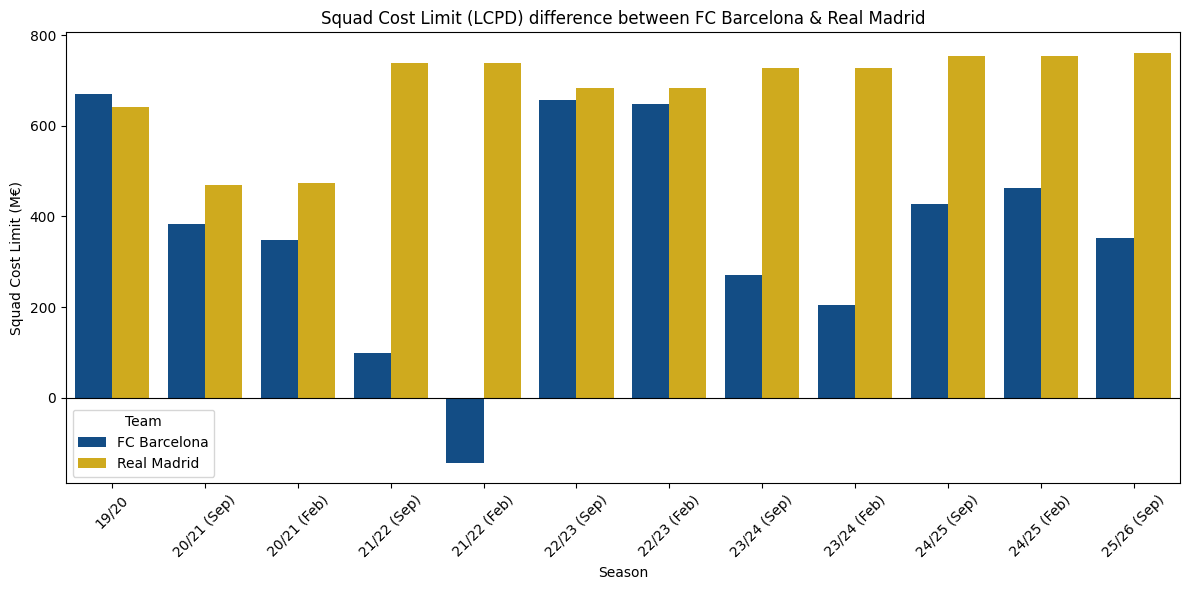

In [18]:
## ========== PLOT 2: Squad Cost Limit Comparison ==========

plt.figure(figsize=(12, 6))

palette = {'FC Barcelona': '#004D98', 'Real Madrid': '#EDBB00'}
sns.barplot(x='Season', y='Squad Cost Limit', hue='Team', data=df4, palette=palette)

plt.title('Squad Cost Limit (LCPD) difference between FC Barcelona & Real Madrid')
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel('Squad Cost Limit (M€)')
plt.legend(title="Team")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Insights: Comparison of Squad Cost Limit between FC Barcelona and Real Madrid
- Squad Cost Limit collapsed after 2020, reaching negative levels in 2021/22.
- Financial restrictions directly correlate with weaker on-field performance.


### Combined Analysis (Correlation)
- Merge cleaned datasets
- Create season-level financial + performance table
- Correlation heatmap
- Scatter + regression (Squad Cost Limit vs Win Rate) plot with seaborn

                  Transfer sum  Squad Cost Limit  win_rate
Transfer sum          1.000000          0.714749  0.042588
Squad Cost Limit      0.714749          1.000000  0.708161
win_rate              0.042588          0.708161  1.000000


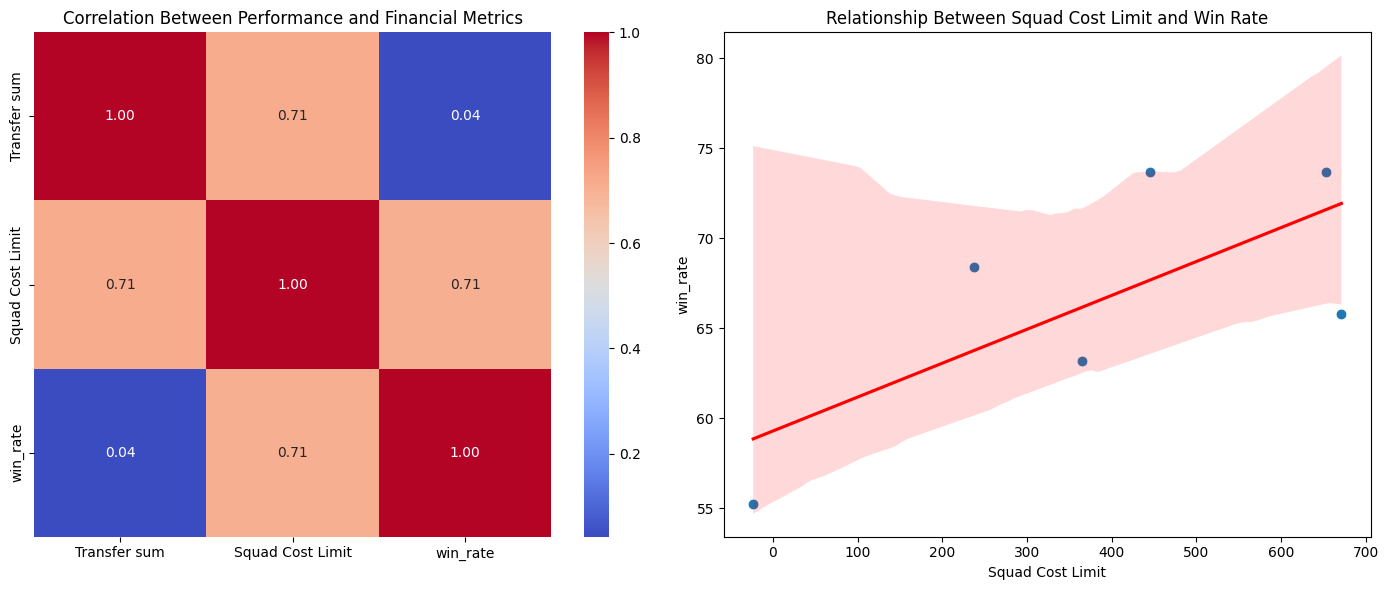

In [19]:
## ========== PLOT 3: Financial Constraints vs Team Performance ==========
merged_df['win_rate'] = (merged_df['Domestic W'] / merged_df['Domestic Match Played'] * 100).round(2)
## Prepare data
merged_df_single = merged_df.drop_duplicates(subset='Season').reset_index(drop=True)
merged_df_single.drop(['Domestic Comp', 'Ball Situation', 'GF', 'GA', 'xG', 'xGA'], axis=1, inplace=True)
merged_df_single = merged_df_single.drop(list(range(0, 5))).reset_index(drop=True)

## FC Barcelona Squad Cost Limit
fcb_df = df4[df4['Team'] == 'FC Barcelona'].copy()
fcb_df['Season_std'] = fcb_df['Season'].str[:5]
fcb_df.drop(['Season'], axis=1)
fcb_df = (fcb_df.groupby('Season_std', as_index=False)[['Squad Cost Limit']] .mean())
fcb_df.rename(columns={'Season_std' : 'Season'}, inplace=True) 

# Combine financial & performance metrics
correlation = merged_df_single.merge(fcb_df, on='Season', how='left')
summary = correlation.merge(df5, on='Season', how='left')

## Compute correlation
numeric_cols = ['Transfer sum', 'Squad Cost Limit', 'win_rate' ]
corr = summary[numeric_cols].corr()
print(corr)

## Plot heatmap & scatter plot + reg plot
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[0])
axes[0].set_title("Correlation Between Performance and Financial Metrics")

ax = axes[1]
sns.scatterplot(data=summary, x='Squad Cost Limit', y='win_rate', ax=ax, s=60)
sns.regplot(data=summary, x='Squad Cost Limit', y='win_rate', ax=ax, scatter=False, color='red')
ax.set_title("Relationship Between Squad Cost Limit and Win Rate")

plt.tight_layout()
plt.savefig("./outputs/figures/financial_and_winrate_correlation.png")
plt.show()


### Interactive Dashboard (Optional)
- Plotly dashboards combining overall key insights of the project
  - La Liga performance trends
  - UCL stage progression
  - Transfer Expenditures
  - Squad Cost Limit 


In [20]:
# Interactive Dashboards
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "La Liga: Goals & Goals Against (2014 - 2025)",
        "UEFA Champions League Stage Progression",
        "Transfer Spending (€M)",
        "Squad Cost Limit Comparison vs Real Madrid (€M)"
    ),
    specs=[
        [{"secondary_y": True}, {}],
        [{}, {}]
    ],
    vertical_spacing=0.12,
    horizontal_spacing=0.08,
)

## La Liga Performance Stats
fig.add_trace(
    go.Scatter(
        x=merged_df["Season"],
        y=merged_df["win_rate"],
        mode="lines+markers",
        name="Win Rate (%)",
        marker=dict(color="#EDBB00", size=20, opacity=0.35),
        line=dict(color="#EDBB00", width=0),
        hovertemplate="Win Rate: %{y:.1f}%<extra></extra>"
    ),
    row=1, col=1,
    secondary_y=False  
)

# Goals For line
fig.add_trace(
    go.Scatter(
        x=merged_df["Season"],
        y=merged_df["Total GF"],
        mode="lines+markers",
        name="Goals For",
        line=dict(color="#004D98", width=3),
        customdata=merged_df[['Total GA','Domestic GD','Domestic Rank']],
        hovertemplate=(
            "Season: %{x}<br>"
            "Goals For: %{y}<br>"
            "Goals Against: %{customdata[0]}<br>"
            "Goal Difference: %{customdata[1]}<br>"
            "League Rank: %{customdata[2]}<extra></extra>"
        )
    ),
    row=1, col=1,
    secondary_y=False
)

# Goals Against line
fig.add_trace(
    go.Scatter(
        x=merged_df["Season"],
        y=merged_df["Total GA"],
        mode="lines+markers",
        name="Goals Against",
        line=dict(color="#A50044", width=3, dash="dot"),
    ),
    row=1, col=1,
    secondary_y=False
)

fig.update_yaxes(title_text="Goals / Win Rate (%)", row=1, col=1, secondary_y=False)

# Annotations for lowest win rate
lowest_win_rate = ["21/22"]
for season in lowest_win_rate:
    value = merged_df.loc[merged_df["Season"] == season, "win_rate"].values[0]
    fig.add_annotation(
        x=season,                  
        y=value,                  
        text=f"{value:.1f}",
        showarrow=False,          
        yshift=18,  
        font=dict(size=12, color="#A50044"),
        row=1, col=1                  
    )
## UCL Progress
competitions = df2['Intl Comp'].unique()
colors = {"1. Champions Lg":"#A50044", "2. Europa Lg":"#004D98"}

## add a trace per competition to the UCL subplot (row=1, col=2)
for comp in competitions:
    comp_df = df2[df2['Intl Comp'] == comp].sort_values('Season')
    
    fig.add_trace(
        go.Scatter(
        x=comp_df['Season'],
        y=comp_df['Stage Progression'],
        mode='lines+markers+text',
        name=f"{comp} Progress",
        text=comp_df['Stage Reached'],
        textposition='top center',
        line=dict(color=colors[comp], width=3),

        customdata=comp_df[['UCL GF', 'UCL GA']],

        hovertemplate=(
            "Season: %{x}<br>"
            "Stage Reached: %{text}<br>"
            "Goals For: %{customdata[0]}<br>"
            "Goals Against: %{customdata[1]}<br>"
            "<extra></extra>"
        ),
    ),
    row=1, col=2
    )

# update y-axis for UCL subplot
fig.update_yaxes(
    tickvals=list(stage_map.values()),
    ticktext=list(stage_map.keys()),
    row=1, col=2
)

## Transfer Spending
fig.add_trace(
    go.Bar(
        x=df5["Season"],
        y=df5["Transfer sum"],
        name="Transfer Spend",
        marker_color="#A50044",
        marker_line_width=0 
    ),
    row=2, col=1
)

## Add annotations
highlight_years = ["17/18", "19/20", "22/23"]

for season in highlight_years:
    value = df5.loc[df5["Season"] == season, "Transfer sum"].values[0]

    fig.add_annotation(
        x=season,                  
        y=value,                  
        text=f"€{value:.0f}M",
        showarrow=False,          
        yshift=12,                
        font=dict(size=12, color="#A50044"),
        bgcolor="rgba(255,255,255,0.8)",
        row=2, 
        col=1                     
    )

# Squad cost limit
teams = df4["Team"].unique()
colors = {"FC Barcelona": "#004D98", "Real Madrid": "#EDBB00"}

for team in teams:
    team_df = df4[df4["Team"] == team]
    fig.add_trace(
        go.Bar(
            x=team_df["Season"],
            y=team_df["Squad Cost Limit"],
            name=team,
            marker_color=colors[team]
        ),
        row=2, col=2
    )

## Layout styling
fig.update_layout(
    height=900, width=1200,
    title={
        'text': "FC Barcelona: A Decade of Performance and Financial Evolution",
        'x': 0.5,
        'xanchor': 'center'
    },
    margin=dict(l=60, r=40, t=100, b=80),
    showlegend=True,
    title_font=dict(size=24, color="#222", family="Arial Black"),
    plot_bgcolor="white",
    paper_bgcolor="white",
    legend=dict(x=0.5, y=-0.1, xanchor='center', orientation='h'),
    hovermode="x unified"
)
fig.update_xaxes(type='category', tickangle=45, automargin=True)
fig.update_yaxes(automargin=True)

fig.write_image("./outputs/figures/overall_key_insights.png")
fig.show()

## Conclusion
- Squad mismanagement (2017–2020) weakened structural stability
- Financial collapse (2020–2022) restricted squad-building capacity
- Efficiency declines in finishing and defense impacted results
- UCL performance mirrored domestic instability
- Financial flexibility strongly predicts competitive performance

> Barcelona’s decade-long trajectory is shaped by the interplay of tactical decisions, squad efficiency, and financial management.

## References & Data Sources
- FBref for performance metrics data
- La Liga for official salary cap data
- Transfermarkt for transfer spending